### Github Repo: https://github.com/ivster/adv_ml_proj

### Explore bivariate results (Use visualizations!)


In [90]:
#install aimodelshare library
! pip install aimodelshare --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
#Get competition data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()


In [92]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


In [163]:
y_train

,Average,High,Low,Very High,Very Low
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
83,1,0,0,0,0
84,0,0,1,0,0
85,0,0,0,1,0
86,1,0,0,0,0


In [162]:
y_train_labels

0       Average
1          High
2       Average
3     Very High
4          High
        ...    
83      Average
84          Low
85    Very High
86      Average
87          Low
Length: 88, dtype: object

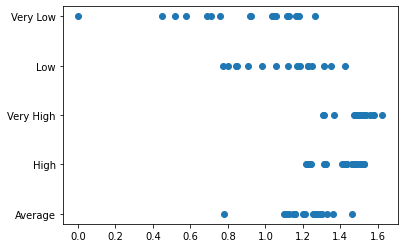

In [169]:
plt.scatter(X_train['Social support'], y_train_labels)

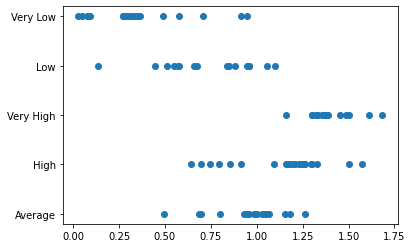

In [160]:
plt.scatter(X_train['GDP per capita'], y_train_labels)

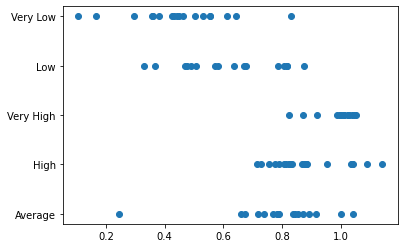

In [164]:
plt.scatter(X_train['Healthy life expectancy'], y_train_labels)

### Describe any relationships you see between particular features and the target variable


#### Based on the bivariate visualizations, we see that countries that thrive better economically and socially (as shown through GDP, social support, and life expectancy) tend to display higher levels of Happiness.

### Examine features that predict happiness categories using one or more models that allow for automatic feature selection.

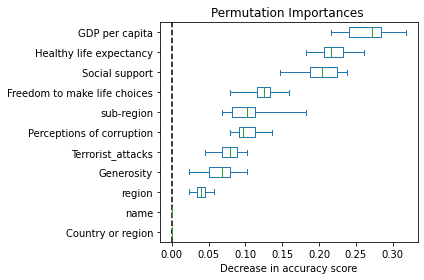

In [149]:
from sklearn.inspection import permutation_importance

rf = Pipeline([
    ('preprocess', preprocess),
    # put your model below
    ('classifier', RandomForestClassifier(n_estimators=500, max_depth=7))
])

rf.fit(X_train, y_train)

result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances ")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Meaningful findings

#### Using random forest classifier, based on the figure above, we see that the features region, generosity, and terrorist attacks are the most important features when trying to predict happiness. This is because we see that they have smaller decreases in their accuracy score, suggesting that they are reliable features in predicting happiness. Also, region had the smallest boxplot, suggesting a small standard deviation, which tells us that the region of where the country is also matters in happiness prediction.

### Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models)

In [93]:
# Preprocessing data 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [94]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [95]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(88, 26)

## MODEL 1: RANDOM FOREST CLASSIFIER

In [96]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_depth=7)
model.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

1.0

In [97]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [98]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [22]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [23]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [24]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 522

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## MODEL 2: LOGISTIC REGRESSION

In [132]:
# Running GridSearch to find parameter

from sklearn.linear_model import LogisticRegression

lrparam_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000]}
lrgrid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid=lrparam_grid)
lrgrid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(lrgrid.best_score_))
print("best parameters: {}".format(lrgrid.best_params_))

best mean cross-validation score: 0.694
best parameters: {'C': 1}


In [133]:
model_2 = LogisticRegression(C=1)
model_2.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_2.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8068181818181818

In [134]:
print("logreg .coef_: {}".format(model_2 .coef_))

logreg .coef_: [[-1.12819771e-01 -3.41299192e-01 -4.20548985e-02 -2.05152575e-01
  -2.44896291e-01  8.64650814e-02  6.18412225e-01 -4.30798653e-02
  -2.76894113e-01  7.50178794e-02  2.52837188e-01 -8.09775256e-03
  -8.09775256e-03  2.94904647e-01  1.95101865e-01  2.17717029e-01
  -2.69886858e-01  4.14205886e-01 -7.00725431e-03 -3.38210517e-01
   2.34517323e-01 -5.07975957e-01  5.12911560e-01 -4.57285751e-01
  -1.41529998e-01 -1.39580884e-01]
 [ 4.46389260e-01  1.20170364e+00  7.93103480e-01  5.95995626e-01
  -4.08197355e-01 -3.10038634e-01 -2.31738441e-01 -2.86802791e-01
   2.12423728e-01  2.32633136e-01 -9.07298486e-02 -6.74401885e-02
  -6.74401885e-02  4.98565468e-01  1.77228479e-01  5.38796279e-01
   3.35720408e-01 -1.06579563e-01 -1.23296680e-01  1.86005237e-01
   3.43968381e-01 -3.66253314e-01 -2.19822885e-01 -1.80223228e-01
  -4.20875879e-01 -5.95708479e-01]
 [-4.40589476e-01 -6.08281679e-01 -7.53149752e-01 -2.67356612e-01
  -3.43802383e-01 -6.03834584e-01 -8.62465858e-01  3.2043

In [135]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [136]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_labels = model_2.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 601

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## MODEL 3: SVC

In [49]:
from sklearn.svm import SVC
model3 = SVC(kernel='linear')

model3.fit(preprocessor(X_train), y_train_labels)


SVC(kernel='linear')

In [153]:
# Tuning for best parameters
from sklearn.model_selection import GridSearchCV
svmparam_grid = {'C': [1, 5, 10, 50],'gamma': [0.0001, 0.0005, 0.001, 0.005]}

svmgrid = GridSearchCV(model3, svmparam_grid)

svmgrid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(svmgrid.best_score_))
print(svmgrid.best_params_)
print(svmgrid.best_estimator_)

best mean cross-validation score: 0.670
{'C': 1, 'gamma': 0.0001}
SVC(C=1, gamma=0.0001, kernel='linear')


In [56]:
# Refitting model with tuned parameters

model3 = SVC(kernel='linear', C= 1, gamma = 0.0001) # kernel and C are the main args to adjust for linear SVC
model3.fit(preprocessor(X_train), y_train_labels)
model3.score(preprocessor(X_train), y_train_labels)

0.8522727272727273

In [84]:
model3.coef_

array([[-9.07306120e-01, -1.23237653e+00, -8.71251439e-01,
        -3.79113214e-01, -5.65584588e-02,  4.74630481e-01,
         3.16254849e-01,  7.90804040e-04, -6.85566168e-01,
         2.00758037e-01,  4.84017327e-01,  0.00000000e+00,
         0.00000000e+00, -8.28866171e-01,  0.00000000e+00,
        -1.33898394e-02, -6.85566168e-01,  7.90804040e-04,
         0.00000000e+00, -4.16086386e-01,  6.07021465e-01,
         0.00000000e+00,  9.13493552e-01,  0.00000000e+00,
         4.22602744e-01,  0.00000000e+00],
       [ 3.43437408e-01,  1.73186572e-01,  3.20091960e-01,
         2.90574491e-01,  1.07319021e-02,  2.43053084e-01,
         1.42524248e+00, -1.52980230e-01,  0.00000000e+00,
        -4.10861360e-01,  5.63841590e-01,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  3.76685552e-01,
         5.82089437e-01,  0.00000000e+00,  9.79798137e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.04787130e+00, -1.82478473e-02, -1.13277837e+00,
        -7.39

In [176]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model3, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [177]:
#Submit Model 3: 

#-- Generate predicted y values (Model 3)
prediction_labels = model3.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 619

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


## MODEL 4: GRADIENT BOOST

In [140]:
bgmodel = GradientBoostingClassifier().fit(preprocessor(X_train), y_train_labels)

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

bgparam_grid = {'n_estimators': [1, 5, 10, 50],'learning_rate': [0.0001, 0.0005, 0.001, 0.005], 'max_depth' : [1, 5, 7, 9]}

bggrid = GridSearchCV(bgmodel, bgparam_grid)

bggrid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(bggrid.best_score_))
print(bggrid.best_params_)
print(bggrid.best_estimator_)

best mean cross-validation score: 0.557
{'learning_rate': 0.005, 'max_depth': 1, 'n_estimators': 50}
GradientBoostingClassifier(learning_rate=0.005, max_depth=1, n_estimators=50)


In [142]:
model4 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.005,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model4.score(preprocessor(X_train), y_train_labels)

0.6477272727272727

In [178]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model4, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [179]:
#Submit Model 4: 

#-- Generate predicted y values (Model 4)
prediction_labels = model4.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 620

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


### Fit and submit 3 more

#### MODEL 1: GRADIENT BOOST

In [180]:
model5 = GradientBoostingClassifier().fit(preprocessor(X_train), y_train_labels)

In [182]:
from sklearn.ensemble import GradientBoostingClassifier

m5param_grid = {'n_estimators': [50, 70, 90, 120],'learning_rate': [0.001, 0.005, 0.01, 0.05], 'max_depth' : [1, 5, 7, 9]}

m5grid = GridSearchCV(model5, m5param_grid)

m5grid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(m5grid.best_score_))
print(m5grid.best_params_)
print(m5grid.best_estimator_)

best mean cross-validation score: 0.637
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 90}
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=90)


In [183]:
model5 = GradientBoostingClassifier(n_estimators=90, learning_rate=0.05,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model5.score(preprocessor(X_train), y_train_labels)

0.9090909090909091

In [204]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model5, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [205]:
#Submit new model 

#-- Generate predicted y values (Model 5)
prediction_labels = model5.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 625

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


#### MODEL 2: BAGGING CLASSIFIER

In [188]:
from sklearn.ensemble import BaggingClassifier

model6 = BaggingClassifier()

m6param_grid = {'n_estimators': [120, 150, 170],'max_samples': [20, 25, 27, 30], 'max_features' : [5, 7, 9, 11]}

m6grid = GridSearchCV(model6, m6param_grid)
m6grid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(m6grid.best_score_))
print(m6grid.best_params_)
print(m6grid.best_estimator_)

best mean cross-validation score: 0.726
{'max_features': 9, 'max_samples': 27, 'n_estimators': 150}
BaggingClassifier(max_features=9, max_samples=27, n_estimators=150)


In [194]:
model6 = GradientBoostingClassifier(n_estimators=150, max_features=9).fit(preprocessor(X_train), y_train_labels)
model6.score(preprocessor(X_train), y_train_labels)

1.0

In [206]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model6, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [207]:
# Submit new model

#-- Generate predicted y values (Model 6)
prediction_labels = model6.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 626

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


#### MODEL 3: SVC

In [202]:
model7 = SVC()

m7param_grid = {'C' : [1, 2, 3, 5, 7], 'gamma': [0.05, 0.1, 0.5], 'kernel' :['rbf', 'linear']}
m7grid = GridSearchCV(model7, m7param_grid)
m7grid.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(m7grid.best_score_))
print(m7grid.best_params_)
print(m7grid.best_estimator_)

best mean cross-validation score: 0.716
{'C': 3, 'gamma': 0.05, 'kernel': 'rbf'}
SVC(C=3, gamma=0.05)


In [203]:
model7 = SVC(C=3, gamma=0.05, kernel='rbf').fit(preprocessor(X_train), y_train_labels)
model7.score(preprocessor(X_train), y_train_labels)

0.8409090909090909

In [208]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model7, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model7.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [209]:
#Submit new model

#-- Generate predicted y values (Model 7)
prediction_labels = model7.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                  custom_metadata={'team': '2'})

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 628

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


### Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

#### After speaking with my team, I tried the Bagging Classifer model and re-tried the SVC and Gradient Boost models again. I changed the parameters using GridSearch again, but this time I tried increasing the parameters from the ones I last used. While my newer models had better cross-validation scores, they didn't seem to perform better on the leaderboard/ test set.

#### Based on the models I've done so far, the best performing model on the leaderboard was my Random Forest Classifier model, with the parameters n_estimators=500, max_depth=7. Following that is my SVC model.